## Currently broken. Adding elec lag features appears to change the learned frequency of the prediction, and I don't know why.

In [ ]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

# plotting libraries
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# preprocessing
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LinearRegression

This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

In [38]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

This cell constructs a DataFrame called X that contains the covariate data. Here, one-hot dates, weather lag, and electricity lag features are added for a total of 45 covariates.

In [56]:
# create X as a copy of y
X = pd.DataFrame(index=y.index)

# add electricity lag features (be careful with this)
elec = pd.DataFrame(index=y.index)
for i in range(1,3):
    elec['elec -'+str(i)] = np.append(np.array([np.nan]*i),y.values[0:len(y)-i])
X = X.join(elec)

# add weather lag features
weather = pd.read_csv('../data/weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')
weather = weather.loc[y.index[0]:y.index[len(y)-1]]
X = X.join(weather)

# add boolean date features
dates = pd.read_csv('../data/date_features.csv',index_col=0)
dates.index = pd.to_datetime(dates.index,format='%Y-%m-%d %H:00:00')
X = X.join(dates)

# truncate y and X to match each other (this step is only necessary if using elec lag features)
X = X.iloc[2:]
y = y.iloc[2:]

Here I would like to implement an iterative linear regression model to more accurately represent the reality of placing bids in the day ahead market. These models will have a test set of just one hour, and the result of each model will be used to predict the following hour.

This is not working right now because the scaler can't be applied to a single row...
Should seek advice on this from statlab or other expert

1. A random day is chosen for analysis, the initial test_start is set
2. Enter a for loop with i from 1 to 39
2. X_train and X_test are created, with X_train = everything before and including start_time + 1

In [57]:
# choose a random day between Jan 10 and July 10 to test
start_times = pd.date_range(start='2018-01-10 08:00:00',end='2018-07-10 08:00:00',freq='D')
first_hour = start_times[np.random.randint(len(start_times))]

# initialize X_pred, a copy of X with y_pred lag features substituted in
X_pred = X.copy(deep=True)
y_pred = y.copy(deep=True)

y_test = y.loc[first_hour+pd.DateOffset(hours=1):first_hour+pd.DateOffset(hours=39)].copy()
y_results = np.array([])

# choose model
model = LinearRegression()

for i in range(1,40):
    # identify the target hour
    target_hour = first_hour + pd.DateOffset(hours=i)
    
    # initialize train and test sets
    X_train = X_pred.loc[X.index < target_hour].copy()
    X_test = X_pred.loc[target_hour].copy()
    y_train = y_pred.loc[y.index < target_hour].copy()

#     # fit standard scalers to the weather and elec features in the training data
    weather_fit = StandardScaler().fit(X_train[weather.columns])
    elec_fit = StandardScaler().fit(X_train[elec.columns])

#     # scale the training and test sets using the scalers fit to the training set
#     X_train[weather.columns] = weather_fit.transform(X_train[weather.columns])
#     X_train[elec.columns] = elec_fit.fit_transform(X_train[elec.columns])
#     X_test[weather.columns] = weather_fit.transform(X_test[weather.columns])
#     X_test[elec.columns] = elec_fit.transform(X_test[elec.columns])
    
    # train the model predict for the target hour, store result in y_results
    reg = model.fit(X_train, y_train)
    y_results = np.append(y_results, reg.predict(np.array(X_test).reshape(1,-1)))
    
    # update X_pred and y_pred to reflect the results of the model
    y_pred.loc[target_hour] = reg.predict(np.array(X_test).reshape(1,-1))
    
    # replace elec lag features in X_pred with predicted data
    elec = pd.DataFrame(index=y.index)
    for i in range(1,3):
        elec['elec -'+str(i)] = np.append(np.array([np.nan]*i),y_pred.values[0:len(y_pred)-i])
    
    X_pred[elec.columns] = elec
    X_pred = X_pred[2:]


In [58]:
results = pd.DataFrame(y_test,columns=['actual'])
results['pred'] = y_results

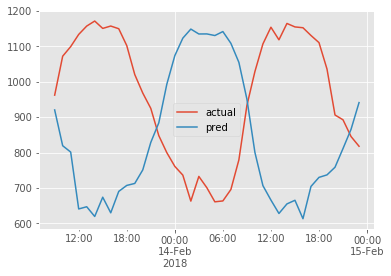

In [59]:
results.plot()